In [5]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import cv2
from collections import deque
import matplotlib.pyplot as plt
import copy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [6]:
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, max_action):
        super(Actor, self).__init__()

        self.l1 = nn.Linear(state_dim, 256)
        self.l2 = nn.Linear(256, 256)
        self.l3 = nn.Linear(256, action_dim)

        self.max_action = max_action

    def forward(self, state):
        a = F.relu(self.l1(state))
        a = F.relu(self.l2(a))
        return self.max_action * torch.tanh(self.l3(a))


In [7]:
class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()

        # Q1 architecture
        self.l1 = nn.Linear(state_dim + action_dim, 256)
        self.l2 = nn.Linear(256, 256)
        self.l3 = nn.Linear(256, 1)

        # Q2 architecture
        self.l4 = nn.Linear(state_dim + action_dim, 256)
        self.l5 = nn.Linear(256, 256)
        self.l6 = nn.Linear(256, 1)

    def forward(self, state, action):
        sa = torch.cat([state, action], 1)

        q1 = F.relu(self.l1(sa))
        q1 = F.relu(self.l2(q1))
        q1 = self.l3(q1)

        q2 = F.relu(self.l4(sa))
        q2 = F.relu(self.l5(q2))
        q2 = self.l6(q2)
        return q1, q2

    def Q1(self, state, action):
        sa = torch.cat([state, action], 1)
        q1 = F.relu(self.l1(sa))
        q1 = F.relu(self.l2(q1))
        q1 = self.l3(q1)
        return q1


In [8]:
class TD3(object):
    def __init__(self, state_dim, action_dim, max_action, discount=0.99, tau=0.005, policy_noise=0.2, noise_clip=0.5, policy_freq=2):
        self.actor = Actor(state_dim, action_dim, max_action).to(device)
        self.actor_target = copy.deepcopy(self.actor)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=3e-4)

        self.critic = Critic(state_dim, action_dim).to(device)
        self.critic_target = copy.deepcopy(self.critic)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=3e-4)

        self.max_action = max_action
        self.discount = discount
        self.tau = tau
        self.policy_noise = policy_noise
        self.noise_clip = noise_clip
        self.policy_freq = policy_freq

        self.total_it = 0

    def select_action(self, state):
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        return self.actor(state).cpu().data.numpy().flatten()

    def train(self, replay_buffer, batch_size=256):
        self.total_it += 1

        state, action, next_state, reward, not_done = replay_buffer.sample(batch_size)
        state = torch.FloatTensor(state).to(device)
        action = torch.FloatTensor(action).to(device)
        next_state = torch.FloatTensor(next_state).to(device)
        reward = torch.FloatTensor(reward).unsqueeze(1).to(device)  # Convert reward to PyTorch tensor

        with torch.no_grad():
            noise = (
                torch.randn_like(action) * self.policy_noise
            ).clamp(-self.noise_clip, self.noise_clip)

            next_action = (
                self.actor_target(next_state) + noise
            ).clamp(-self.max_action, self.max_action)

            # Compute the target Q value
            target_Q1, target_Q2 = self.critic_target(next_state, next_action)
            target_Q = torch.min(target_Q1, target_Q2)
            target_Q = reward + torch.tensor(not_done, dtype=torch.float32).to(device) * self.discount * target_Q

        current_Q1, current_Q2 = self.critic(state, action)

        critic_loss = F.mse_loss(current_Q1, target_Q) + F.mse_loss(current_Q2, target_Q)

        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        if self.total_it % self.policy_freq == 0:
            actor_loss = -self.critic.Q1(state, self.actor(state)).mean()

            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            self.actor_optimizer.step()

            for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
                target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

            for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
                target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

    def save(self, filename):
        torch.save(self.critic.state_dict(), filename + "_critic")
        torch.save(self.critic_optimizer.state_dict(), filename + "_critic_optimizer")

        torch.save(self.actor.state_dict(), filename + "_actor")
        torch.save(self.actor_optimizer.state_dict(), filename + "_actor_optimizer")

    def load(self, filename):
        self.critic.load_state_dict(torch.load(filename + "_critic"))
        self.critic_optimizer.load_state_dict(torch.load(filename + "_critic_optimizer"))
        self.critic_target = copy.deepcopy(self.critic)

        self.actor.load_state_dict(torch.load(filename + "_actor"))
        self.actor_optimizer.load_state_dict(torch.load(filename + "_actor_optimizer"))
        self.actor_target = copy.deepcopy(self.actor)


In [9]:
class ReplayBuffer(object):
    def __init__(self, state_dim, action_dim, max_size=1e6):
        self.storage = deque(maxlen=int(max_size))
        self.max_size = max_size
        self.state_dim = state_dim
        self.action_dim = action_dim

    def add(self, state, action, next_state, reward, done):
        if isinstance(state, tuple):
            state = state[0]  
        action = np.array(action)
        state = np.array(state)
        next_state = np.array(next_state)
        reward = np.array(reward)

        transition = (state, action, next_state, reward, done)
        self.storage.append(transition)

    def sample(self, batch_size):
        if len(self.storage) < batch_size:
            raise ValueError("Not enough samples in the replay buffer to sample a batch.")

        batch_indices = np.random.choice(len(self.storage), size=batch_size, replace=False)
        batch_states, batch_actions, batch_next_states, batch_rewards, batch_dones = [], [], [], [], []

        for idx in batch_indices:
            state, action, next_state, reward, done = self.storage[idx]
            # Check the shape of each element before appending
            if state.shape != (self.state_dim,):
                state = np.array(state)
            if action.shape != (self.action_dim,):
                action = np.array(action)
            if next_state.shape != (self.state_dim,):
                next_state = np.array(next_state)
            if reward.shape != (1,):
                reward = np.array(reward)
            # Append to batch arrays
            batch_states.append(state)
            batch_actions.append(action)
            batch_next_states.append(next_state)
            batch_rewards.append(reward)
            batch_dones.append(done)

        return (
            np.array(batch_states),
            np.array(batch_actions),
            np.array(batch_next_states),
            np.array(batch_rewards),
            np.array(batch_dones)
        )


In [10]:
def evaluate_policy(env, policy, eval_episodes=10):
    avg_reward = 0.
    for _ in range(eval_episodes):
        state, done = env.reset(), False
        if isinstance(state, tuple):
            state = state[0]
        while not done:
            action = policy.select_action(np.array(state))
            state, reward, terminated, truncated, _ = env.step(action)
            if isinstance(state, tuple):
                state = state[0]
            done = terminated or truncated
            avg_reward += reward

    avg_reward /= eval_episodes
    return avg_reward

def plot_rewards(rewards, filename):
    plt.plot(rewards)
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('Training Progress')
    plt.savefig(filename)
    plt.show()


---------------------------------------
Final Evaluation over 200 evaluations: -149.41509160527434
---------------------------------------


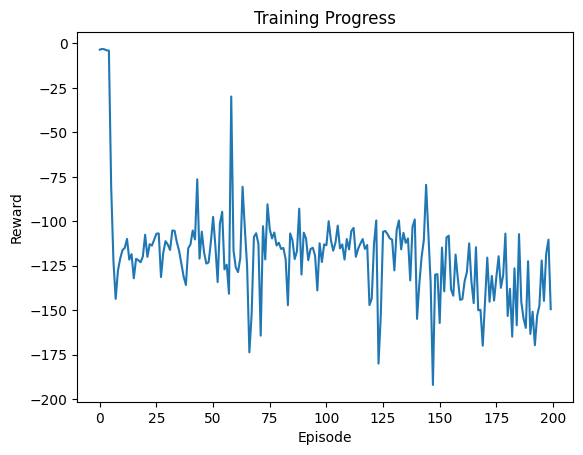

In [11]:
def main():
    env_name = "BipedalWalker-v3"
    env = gym.make(env_name, render_mode='rgb_array')

    seed = 0
    env.reset(seed=seed)
    torch.manual_seed(seed)
    np.random.seed(seed)

    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    max_action = float(env.action_space.high[0])

    # Initialize policy and replay buffer
    policy = TD3(state_dim, action_dim, max_action)
    replay_buffer = ReplayBuffer(state_dim, action_dim)

#     Parameters
#     start_timesteps = 25e3
#     eval_freq = 5e3
#     max_timesteps = 1e6
#     expl_noise = 0.1
#     batch_size = 256
#     discount = 0.99
#     tau = 0.005
#     policy_noise = 0.2
#     noise_clip = 0.5
#     policy_freq = 2


    start_timesteps = 5000  # Reduced from 25e3
    eval_freq = 1000        # Reduced from 5e3
    max_timesteps = 200000  # Reduced from 1e6
    batch_size = 64         # Reduced from 256
    expl_noise = 0.05       # Reduced from 0.1
    discount = 0.99
    tau = 0.005
    policy_noise = 0.2
    noise_clip = 0.5
    policy_freq = 2
    
    
    # Training Loop
    state, done = env.reset(), False
    if isinstance(state, tuple):
        state = state[0]
    episode_reward = 0
    episode_timesteps = 0
    episode_num = 0

    evaluations = []

    for t in range(int(max_timesteps)):
        episode_timesteps += 1

        if t < start_timesteps:
            action = env.action_space.sample()
        else:
            action = (
                policy.select_action(np.array(state))
                + np.random.normal(0, max_action * expl_noise, size=action_dim)
            ).clip(-max_action, max_action)

        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        if isinstance(next_state, tuple):
            next_state = next_state[0]

        replay_buffer.add(state, action, next_state, reward, done)

        state = next_state
        episode_reward += reward

        if t >= start_timesteps:
            policy.train(replay_buffer, batch_size)

        if done:
            state, done = env.reset(), False
            if isinstance(state, tuple):
                state = state[0]
            episode_reward = 0
            episode_timesteps = 0
            episode_num += 1

        if (t + 1) % eval_freq == 0:
            evaluations.append(evaluate_policy(env, policy))
    
    print("---------------------------------------")
    print(f"Final Evaluation over {len(evaluations)} evaluations: {evaluations[-1] if evaluations else 'N/A'}")
    print("---------------------------------------")
    plot_rewards(evaluations, 'training_rewards.png')

if __name__ == "__main__":
    main()